## Problem Statement

When engaging with content in our model world, corporations use recommender system to suggest future content we might like based on the attributes of the content. Be it movies or books that we may be interested in with the goal of keeping customer interested andf However this may cause an echo chamber effect.

An extreme example of an echo chamber caused by recommender system is youtube's algorithm suggesting alt-right content which may lead to an individual developing extremist views. And this a problem of overtraining, because what is recommended is based on the data that is inputed to the system. 

Spotify uses a common method for producing recommendations known as collaborative filtering which generates recommendations based on the combined preferences of the consumer requesting recommendations and those of other consumers. The underlying issue with this method is that song recommendations are based on the 'crowd'.

Furthermore, as the business model of Spotify is built in a way where artists are compensated by number of streams, the homegenization of new music become more prevalent. Such as making songs more catchier and shorter. 

The recommender system I would like to propose is for users to be recommended songs based on the 'DNA' of the music they have been listening to with the goal of potentially exposing the listener to songs form different genres and epochs. This is threfore a cluster or nearest neighbour recommendation system. This would broaden the horizon of music listeners and also bring attention to artists that create music as an artform as opposed to achieving the highest streaming numbers. 

Things to do
- clean the data
- assign the song with their respective genre
- cluster the cleaned data

- random forest classifier

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

from numpy import dot
from numpy.linalg import norm


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE

plt.style.use('fivethirtyeight')



# Datasets for Artist information (from Spotify Songs Kaggle dataset)

In [2]:
artist_df = pd.read_csv('../data/spotify_songs_1922/artists.csv')
data_by_artist_df = pd.read_csv('../data/spotify_songs_1922/data_by_artist_o.csv')
tracks_df = pd.read_csv('../data/spotify_songs_1922/tracks.csv')
data_df = pd.read_csv('../data/spotify_songs_1922/data_o.csv')
data_by_year_df = pd.read_csv('../data/spotify_songs_1922/data_by_year_o.csv')
data_by_genres_df = pd.read_csv('../data/spotify_songs_1922/data_by_genres_o.csv')

## Decisions Moving Forward
- Using non explicit songs as there are more 
- consider making a decade categorical feature
- clustering genres together as genres are are not generalised


## Modelling:

### Feature Engineering

- using K-means(or other clustering techniques) to cluster genre together 
- should also look into other clustering methods

- Should I use a a linear regression model to see the type of features is most important in the song prediction? https://medium.com/@mark.rethana/building-a-song-recommendation-system-using-cosine-similarity-and-euclidian-distance-748fdfc832fd


### Metrics

- Unsure if the metric is subject to the listener


### Building the Recommender System
- Naive and non personalised way by recreating the Collab Filtering as a baseline
- using distance to build a recommender system via clustered genres
- Using CNN as a recommender system
    - emulating this research paper https://www.sciencedirect.com/science/article/pii/S1877050919310646/pdf?md5=4f9a5242eb223b5c96c9ebf130855467&pid=1-s2.0-S1877050919310646-main.pd
- using cosine similarity

### Potential Limitations and Considerations

- kaggle dataset does not have user engagement and only genre metadata

 - do i need to use the million dataset as i need a rating system to work on?
     - current spotify dataset may not have enough features
     - Source of dataset: http://millionsongdataset.com/
     - This article uses it https://towardsdatascience.com/how-to-build-a-simple-song-recommender-296fcbc8c85
    
     
     
 - Show why Collab filtering is not ideal due to the the cold start problem, also suggesting niche recommendation, requires reference from what may be a scare dataset. Generally why collab filtering would create an echo chamber because popularity of the music can be affected exogenous factors such as hype around the artist, your social group and so on. 
 
 

#### helpful research links

- https://www.nytimes.com/2009/10/18/magazine/18Pandora-t.html
- https://towardsdatascience.com/4-ways-to-supercharge-your-recommendation-system-aeac34678ce9
- https://soundcharts.com/blog/music-industry-trends#the-democratization-of-music-creation

## Data Dictionary

## Datasets Description

#### artist_df
- shows popularity
- shows number of followers
- shows genre

#### data_by_artist_df
- 28680 artists
- gives average of the songs metadeta made by the artist. 
- Think of as the music DNA of the artist
- Also provides a list of genre the artist is categorised in.
 
#### tracks_df (songs)
- 586672 songs
- Does not have genre IMPORTANT
- has repeats of the same song with the same specs, possibly rereleased.
- does not have year or release date
- has song metadata.

#### data_df (songs)
- 170653 songs
- does not have genre
- has release dates and year in the dataset
- has song meta deta

#### data_by_year
- shows average of music data that year
- Useful for EDA
    - show trend of how music has evolved over the years
    - plot graph
    
    
#### data_by_genre_df
- dataset has 2973 subgenres 
- features associated with these subgenres are the average values that a song belonging to that subgenre would have.


observation, the longest song duration in the dataset shows to be 90 minutes long. These are likely to be podcast are maybe comedy albums that comedians have put out. Or could also be audio of soundscapes people use for mediation. Ultimately for my project, with the knowledge that most popular songs are under 10 minutes. I would remove all songs that exceed this duration. 

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [4]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [5]:
data_by_genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


In [6]:
artist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104349 entries, 0 to 1104348
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1104349 non-null  object 
 1   followers   1104336 non-null  float64
 2   genres      1104349 non-null  object 
 3   name        1104349 non-null  object 
 4   popularity  1104349 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 42.1+ MB


## Data Cleaning

In [7]:
#inspect general distribution of each feature
data_df.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


In [8]:
print(f"Number of songs that were over 10 minutes: {len(data_df[data_df.duration_ms > 600000].index)}")

Number of songs that were over 10 minutes: 2265


In [91]:
#drop songs that are over 10 minutes
data_df = data_df.drop(data_df[data_df.duration_ms > 600000].index)
#reset index
data_df.reset_index(drop = True,inplace = True)

### Check for duplicates

In [14]:
data_df.tail()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
170648,0.608,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
170649,0.734,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
170650,0.637,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.195,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055
170652,0.642,2020,0.13200,"['KEVVO', 'J Balvin']",0.856,189507,0.721,1,7HmnJHfs0BkFzX4x8j0hkl,0.004710,7,0.1820,-4.928,1,Billetes Azules (with J Balvin),74,2020-10-16,0.1080,94.991


In [15]:
data_df[data_df['artists'].str.contains("Drake")].head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
4210,0.361,1943,0.975,"['Alfred Drake', 'Oklahoma Chorus']",0.400,152120,0.308,0,18Lxour9k0zowOzlPIrlPF,0.000412,3,0.0807,-10.749,1,"Oh, What A Beautiful Mornin'",19,1943-12-02,0.0389,81.336
4213,0.765,1943,0.887,"['Alfred Drake', 'Oklahoma Chorus']",0.672,150493,0.441,0,1gmK889zKeVBpdmkv0hv4N,0.000000,6,0.1220,-10.989,0,Oklahoma,16,1943-12-02,0.1700,68.552
4232,0.184,1943,0.940,"['Alfred Drake', 'Joan Roberts']",0.349,190053,0.159,0,1HuIThAQ9aWdUJ2118ov8i,0.000000,1,0.1800,-12.689,1,People Will Say We're In Love,9,1943-12-02,0.0379,78.985
4244,0.377,1943,0.918,['Alfred Drake'],0.571,187013,0.155,0,3vSsJRF0UIlR7DAT6aS9nW,0.000000,9,0.1260,-12.843,1,The Surrey With The Fringe On Top,7,1943-12-02,0.0871,80.847
4264,0.279,1943,0.873,"['Alfred Drake', 'Howard Da Silva']",0.399,169667,0.160,0,1TIzYuKM2ZzznANW4q9axG,0.000000,4,0.1850,-13.306,1,Pore Jud Is Daid,3,1943-12-02,0.0347,135.557


In [16]:
#check for number of artist with blank genres
artist_df[artist_df.genres == '[]'].shape[0]

805733

In [17]:
#check for number of duplicates in artist and genre name column
artist_df.duplicated(subset=['name','genres']).sum()

13608

In [18]:
data_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665
5,0.1960,1921,0.579,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.697,395076,0.346,0,4pyw9DVHGStUre4J6hPngr,0.168000,2,0.130,-12.506,1,Gati Mardika,6,1921,0.0700,119.824


In [19]:
artist_df[artist_df.name == 'Sergei Rachmaninoff']

,id,followers,genres,name,popularity
129223,00VKDHxPq437kxPuiBoh1u,2.0,[],Sergei Rachmaninoff,0
143111,0Kekt6CKSo0m5mivKcoH51,473845.0,"['classical', 'post-romantic era', 'russian ro...",Sergei Rachmaninoff,66


### data_df

In [20]:
# check for Ashnikko result for the Song 'Daisy' in data_df dataset
data_df[(data_df.artists == "['Ashnikko']") & (data_df.name == "Daisy")]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
19638,0.774,2020,0.235,['Ashnikko'],0.834,146523,0.663,1,0AUvWawuP0ibk4SQ3sIZjk,0.0,8,0.372,-6.143,1,Daisy,90,2020-07-09,0.133,121.876


In [21]:
# check for Ashnikko result for the Song 'Daisy' in track_df dataset
tracks_df[(tracks_df.artists == "['Ashnikko']") & (tracks_df.name == "Daisy")]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
93137,0AUvWawuP0ibk4SQ3sIZjk,Daisy,82,146523,1,['Ashnikko'],['3PyJHH2wyfQK3WZrk9rpmP'],2020-07-09,0.834,0.663,8,-6.143,1,0.133,0.235,0.0,0.372,0.774,121.876,4
94181,2g1KggY9PKvsoEAOaiz4xx,Daisy,77,146523,1,['Ashnikko'],['3PyJHH2wyfQK3WZrk9rpmP'],2021-01-15,0.834,0.663,8,-6.143,1,0.133,0.235,0.0,0.372,0.774,121.876,4


comments:
tracks_df may have duplicates, one example thus far is difference in release dates. 

Comparing the same song between data_df and tracks_df, they share the same ID for one of them however certain attribute have different values, such as popularity.

In [22]:
# check for Drake result for the Song 'Daisy' in data_df dataset
data_df[(data_df.artists == "['Drake']") & (data_df.name == "Best I Ever Had")]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
17419,0.558,2009,0.1900,['Drake'],0.395,257690,0.922,1,3QLjDkgLh9AOEHlhQtDuhs,0.0,1,0.134,-2.176,1,Best I Ever Had,73,2009,0.375,162.361
17795,0.605,2010,0.0951,['Drake'],0.431,258760,0.894,1,1GxHeBvQ9935Dd3cSfsfBa,0.0,5,0.188,-2.673,0,Best I Ever Had,63,2010-01-01,0.330,162.161


In [23]:
# check for Drake result for the Song 'Daisy' in tracks_df dataset
tracks_df[(tracks_df.artists == "['Drake']") & (tracks_df.name == "Best I Ever Had")]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
82191,3QLjDkgLh9AOEHlhQtDuhs,Best I Ever Had,76,257690,1,['Drake'],['3TVXtAsR1Inumwj472S9r4'],2009,0.395,0.922,1,-2.176,1,0.375,0.1900,0.0,0.134,0.558,162.361,4
83429,1GxHeBvQ9935Dd3cSfsfBa,Best I Ever Had,65,258760,1,['Drake'],['3TVXtAsR1Inumwj472S9r4'],2010-01-01,0.431,0.894,5,-2.673,0,0.330,0.0951,0.0,0.188,0.605,162.161,4
186615,1PWnjvzT5Jhpfnh96DRNDh,Best I Ever Had,51,258800,0,['Drake'],['3TVXtAsR1Inumwj472S9r4'],2009-01-01,0.441,0.904,1,-2.636,1,0.359,0.1020,0.0,0.196,0.529,161.740,4


comments: For the example above, the same song had more than 1 output. For Data_df their release year and date is different as well as some attributes such as 'danceability'. This may indicate that the song was release twice, perhaps the latter was remastered and released in an album and not just as a single like the first time. Tracks_df does not have release date that information. 

data_df seem to not have the song non-explicit version of the song as well. 

Will investigate on more time. With the classic song "Here Comes the Sun" by the Beatles.

In [25]:
# check for Beatles result for the Song 'Here Comes the Sun' in data_df dataset
data_df[(data_df.artists == "['The Beatles']") & (data_df.name == "Here Comes The Sun")]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo


comment: No song to be found, however the remastered version is available.

In [26]:
# check for Beatles result for the Song 'Here Comes the Sun' in tracks_df dataset
tracks_df[(tracks_df.artists == "['The Beatles']") & (tracks_df.name == "Here Comes The Sun - Remastered 2009")]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
42488,6dGnYIeXmHdcikdzNNDMm2,Here Comes The Sun - Remastered 2009,83,185733,0,['The Beatles'],['3WrFJ7ztbogyGnTHbHJFl2'],1969-09-26,0.557,0.540,9,-10.484,1,0.0347,0.0339,0.00248,0.179,0.394,129.171,4
47141,5bIEpKwEFgJzB7U3gFaeKm,Here Comes The Sun - Remastered 2009,41,187373,0,['The Beatles'],['3WrFJ7ztbogyGnTHbHJFl2'],1973-04-02,0.557,0.519,9,-11.164,1,0.0357,0.0362,0.00126,0.105,0.371,129.157,4


In [27]:
# check for Beatles result for the Song 'Here Comes the Sun' in data_df dataset
data_df[(data_df.artists == "['The Beatles']") & (data_df.name == "Here Comes The Sun - Remastered 2009")]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
9407,0.394,1969,0.0339,['The Beatles'],0.557,185733,0.540,0,6dGnYIeXmHdcikdzNNDMm2,0.00248,9,0.179,-10.484,1,Here Comes The Sun - Remastered 2009,82,1969-09-26,0.0347,129.171
65653,0.371,1973,0.0362,['The Beatles'],0.557,187373,0.519,0,5bIEpKwEFgJzB7U3gFaeKm,0.00126,9,0.105,-11.164,1,Here Comes The Sun - Remastered 2009,40,1973-04-02,0.0357,129.157


Comments: For this song only the remastered version is available on spotify, and they still appear to have different characteristics, such as popularity, duration and energy.

Difference in popularity can be explained by the song being in an alubm that may have not been marketed as well or listeners feel that that album does not have other songs they would enjoy. For example the song that had a lower popularity score belonged to the album 'The Beatles 1967-1970' whereas the song with the higher popularity had belonged to the album 'Abbey Road (remasted)' where its a bigger compliation of classic by the band. 


#### Conclusion

Datasets that would be used for EDA would be data_by_year_df.

Dataset that would be used would be used for modelling would be data_df as it has more information compared to track_df. During comparison, useful information had also reveal itself such as that non exact 'duplicate' of the same song, are rereleased or remastered. This may affect their popularity, but moving forward, I believe that the granualirity of the popularity does not matter and I would threfore bucket them, making this feature categorical. 

In terms of duplicates as one song is the remastered version of the other. By definition, remastering music is essentially improving on the quality of the original copy of a song or album. Removing flaws from the music, providing a cleaner, sharper and more refined listening experience whilst trying to bringing the music up to date with current standard. After remastering, certain attributes of the song would still generally remain the same, such as key, time signature, duration, tempo and speechiness. Nonetheless these duplicates, I would not remove them, as there are some music enthusiast that actually prefered 'non tampered' music. However I would remove songs that are duplicates where they have the same exact, values in terms of audio features. These are songs that appear multiple times in different albums.

Also, there are some artist that generally do not make explicit music, and would therefore not have duplicates of the same song where they only differ in explicity. Removing duplciates by only keeping explicit songs would therefore result in removing many artists.


In [81]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168388 entries, 1 to 170652
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           168388 non-null  float64
 1   year              168388 non-null  int64  
 2   acousticness      168388 non-null  float64
 3   artists           168388 non-null  object 
 4   danceability      168388 non-null  float64
 5   duration_ms       168388 non-null  int64  
 6   energy            168388 non-null  float64
 7   explicit          168388 non-null  int64  
 8   id                168388 non-null  object 
 9   instrumentalness  168388 non-null  float64
 10  key               168388 non-null  object 
 11  liveness          168388 non-null  float64
 12  loudness          168388 non-null  float64
 13  mode              168388 non-null  int64  
 14  name              168388 non-null  object 
 15  popularity        168388 non-null  int64  
 16  release_date      16

In [83]:
#put all audio features into list
audio_features = ['tempo','speechiness','speechiness','mode','loudness','liveness','key','instrumentalness','energy','danceability','acousticness','valence']

In [92]:
duplicate_rows = data_df[data_df.duplicated(subset=audio_features, keep='first')].index

In [95]:
#drop duplicated rows and reset index
data_df.drop(duplicate_rows,inplace=True)
data_df.reset_index(drop=True, inplace=True)

In [142]:
#drop rows that also have the same artist and song title incase they happen to have different audio features. remastered songs tend to have 'remastered' in its name
duplicate_name_rows = data_df[data_df.duplicated(subset=['name','artists'], keep='first')].index

In [145]:
#drop duplicated rows and reset index
data_df.drop(duplicate_name_rows,inplace=True)
data_df.reset_index(drop=True, inplace=True)

### Reformmating Artist Column

I had observed earlier that artists seem to be in lists in artist column in data_df

In [28]:
data_df.artists[15]

"['Sergei Rachmaninoff', 'Ruth Laredo']"

In [29]:
data_df.artists[15][0] #check to see if it is a list

'['

As we can see from above, it was a list, 'Sergio Racmaninoff' would have been returned.

artist and genre columns, they are actually not list, but strings that look like list. 
we shall therefore use a function to transform these elements into cleaned string.

In [30]:
"""function to transfor string
list into actual string """

def clean_string_main_artist(x):
    #remove square brackets
    x = x.replace('[','')
    x = x.replace(']','')
    
    #making into list by spliting at comma
    list_of_artist = x.split(", ")
    
    #transform individual elements 
    for artist in range(len(list_of_artist)):
        list_of_artist[artist] = list_of_artist[artist].replace("'","")  
    
    #return the main artist in the list, main artist are the first in the list and the featuring artist are artist proceeding
    return list_of_artist[0]

In [31]:
data_df['main_artist'] = data_df['artists'].apply(lambda x: clean_string_main_artist(x))

In [32]:
data_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Frank Parker
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan
5,0.1960,1921,0.579,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.697,395076,0.346,0,4pyw9DVHGStUre4J6hPngr,0.168000,2,0.130,-12.506,1,Gati Mardika,6,1921,0.0700,119.824,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...


In [33]:
"""function to transfor string
list into actual string """

def clean_string_featuring_artist(x):
    #remove square brackets
    x = x.replace('[','')
    x = x.replace(']','')
    
    #making into list by spliting at comma
    list_of_artist = x.split(", ")
    
    #transform individual elements 
    for artist in range(len(list_of_artist)):
        list_of_artist[artist] = list_of_artist[artist].replace("'","")  
    
    #return featuring artist are artist proceeding
    return list_of_artist[1:]

In [34]:
data_df['feat_artist'] = data_df['artists'].apply(lambda x: clean_string_featuring_artist(x))

In [35]:
data_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist,feat_artist
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day,[]
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Frank Parker,[]
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan,[]
5,0.1960,1921,0.579,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.697,395076,0.346,0,4pyw9DVHGStUre4J6hPngr,0.168000,...,0.130,-12.506,1,Gati Mardika,6,1921,0.0700,119.824,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]


## Exploratory Data Analysis

In [36]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168388 entries, 1 to 170652
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           168388 non-null  float64
 1   year              168388 non-null  int64  
 2   acousticness      168388 non-null  float64
 3   artists           168388 non-null  object 
 4   danceability      168388 non-null  float64
 5   duration_ms       168388 non-null  int64  
 6   energy            168388 non-null  float64
 7   explicit          168388 non-null  int64  
 8   id                168388 non-null  object 
 9   instrumentalness  168388 non-null  float64
 10  key               168388 non-null  int64  
 11  liveness          168388 non-null  float64
 12  loudness          168388 non-null  float64
 13  mode              168388 non-null  int64  
 14  name              168388 non-null  object 
 15  popularity        168388 non-null  int64  
 16  release_date      16

In [37]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [38]:
artist_df.popularity.sort_values(ascending=False)

144481    100
126338     98
313676     98
115489     98
144484     96
         ... 
619749      0
619748      0
619747      0
619746      0
0           0
Name: popularity, Length: 1104349, dtype: int64

In [39]:
artist_df.iloc[144481,:]

id                              1uNFoZAHBGtllmzznpCI3s
followers                                   4.4607e+07
genres        ['canadian pop', 'pop', 'post-teen pop']
name                                     Justin Bieber
popularity                                         100
Name: 144481, dtype: object

comment: Justin Bieber is the most popular artist

In [40]:
artist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104349 entries, 0 to 1104348
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1104349 non-null  object 
 1   followers   1104336 non-null  float64
 2   genres      1104349 non-null  object 
 3   name        1104349 non-null  object 
 4   popularity  1104349 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 42.1+ MB


In [41]:
data_df.shape

(168388, 21)

In [42]:
data_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist,feat_artist
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day,[]
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Frank Parker,[]
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan,[]
5,0.1960,1921,0.579,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.697,395076,0.346,0,4pyw9DVHGStUre4J6hPngr,0.168000,...,0.130,-12.506,1,Gati Mardika,6,1921,0.0700,119.824,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]


In [43]:
tracks_df.shape

(586672, 20)

In [44]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [45]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168388 entries, 1 to 170652
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           168388 non-null  float64
 1   year              168388 non-null  int64  
 2   acousticness      168388 non-null  float64
 3   artists           168388 non-null  object 
 4   danceability      168388 non-null  float64
 5   duration_ms       168388 non-null  int64  
 6   energy            168388 non-null  float64
 7   explicit          168388 non-null  int64  
 8   id                168388 non-null  object 
 9   instrumentalness  168388 non-null  float64
 10  key               168388 non-null  int64  
 11  liveness          168388 non-null  float64
 12  loudness          168388 non-null  float64
 13  mode              168388 non-null  int64  
 14  name              168388 non-null  object 
 15  popularity        168388 non-null  int64  
 16  release_date      16

In [46]:
for x in data_df.columns:
    if x not in tracks_df.columns:
        print (x)

year
main_artist
feat_artist


In [47]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

### creating scaled dataframe for eda

In [48]:
lin_graph = data_by_year_df.iloc[:,2:]
ss = StandardScaler()
lin_graph_data = ss.fit_transform(lin_graph)
#lin_graph_data = pd.concat([lin_graph,data_by_year_df.year],axis=1)

In [49]:
lin_graph_data = pd.DataFrame(data = lin_graph_data, columns=data_by_year_df.iloc[:,2:].columns.values)

In [50]:
graph_data = pd.concat([lin_graph_data,data_by_year_df.year],axis=1)

In [51]:
graph_data

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,year
0,1.206593,-2.268729,1.303465,-1.372612,1.241416,-0.141117,-1.643865,-0.394037,-2.567559,-2.656372,-1.297256,-0.504959,1921
1,1.395278,-1.050819,-2.424439,-1.335327,1.974278,1.824215,-2.364442,0.132090,-2.682246,0.059618,-1.322135,1.751841,1922
2,1.463369,0.778558,-1.935347,-1.182517,1.461764,1.079979,-0.699070,-0.145779,-0.355409,1.623313,-1.067354,-1.069159,1923
3,1.401148,0.251686,-1.421483,-0.673342,3.184595,1.515427,-0.732122,-0.168531,0.828525,2.288008,-1.296883,1.751841,1924
4,1.482933,0.711808,-1.659106,-1.081931,1.843836,1.652901,-0.704637,0.074121,-0.087526,1.561357,-1.202546,0.341341,1925
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.993316,1.217422,-0.231368,0.870891,-0.817217,-1.518719,1.264707,-0.018941,0.467444,-1.748761,1.566603,-1.069159,2016
96,-0.986279,1.448058,-0.634512,0.855765,-0.791730,-0.926886,1.183293,0.057215,0.210427,-2.010511,1.742160,-0.787059,2017
97,-1.053679,2.432513,-0.835076,0.930417,-1.143516,-1.790666,1.553464,0.260836,1.047048,-1.463828,1.743747,-0.787059,2018
98,-1.014750,2.073803,-1.030209,0.873183,-0.951324,-1.998883,1.374370,0.185793,0.748059,-1.274391,1.838910,-0.787059,2019


<AxesSubplot:xlabel='year'>

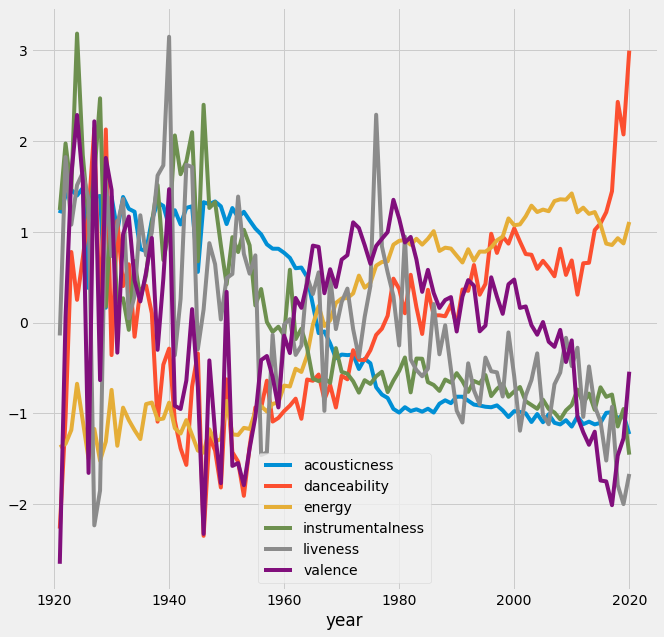

In [52]:
graph_data[["acousticness","danceability","energy", 
         "instrumentalness", "liveness", "valence","year"]].set_index('year').plot(kind='line',figsize=(10,10))

comments: General EDA, not very useful in producing meaningful insight. Moving forward, I will explore more trends related to the problem satement

## More Ideas for EDA

- show how duration of music has shorten over time
- show relation to popular music and short duration, indicative of our shortened attention span
- show how prevalence of genre has affected our music taste
- show how genre populartiy has changed

### show how duration of music has shorten over time

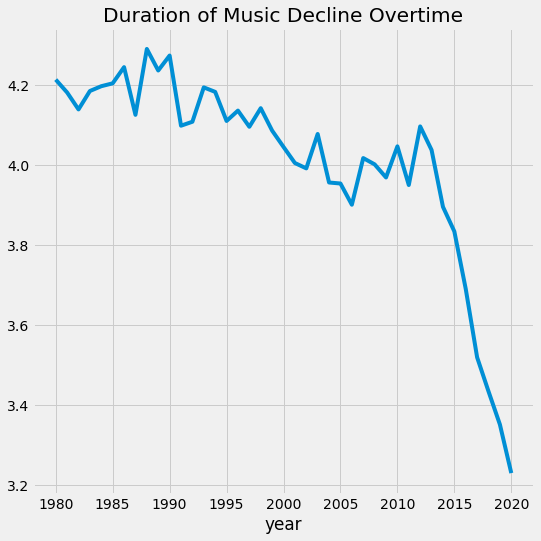

In [156]:
#plot the duration of songs in minute across time
plt.figure(figsize=(8,8))
(data_by_year_df[(data_by_year_df.year >= 1980)].groupby('year')['duration_ms'].mean()/60000).plot() #group data by year, take the average duration per year and plot
plt.title('Duration of Music Decline Overtime')
plt.savefig('../images/duration-of-music-decline-overtime.png');

In [54]:
(data_by_year_df.groupby('year')['duration_ms'].mean()/60000)

year
1921    4.342286
1922    2.757829
1923    2.965706
1924    3.184112
1925    3.083115
          ...   
2016    3.689942
2017    3.518595
2018    3.433350
2019    3.350413
2020    3.228807
Name: duration_ms, Length: 100, dtype: float64

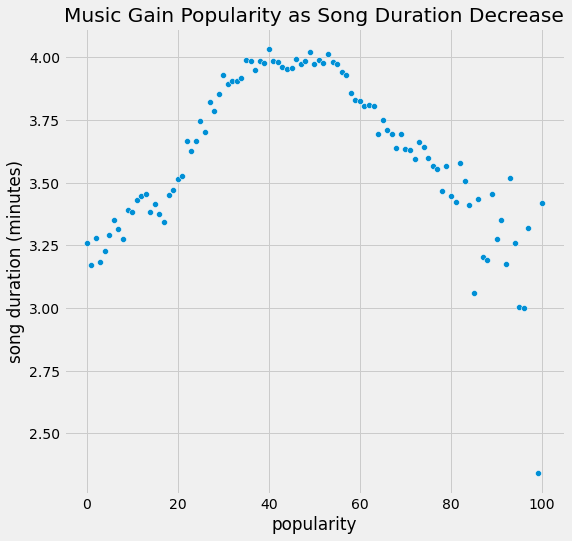

In [55]:
#plot the duration of songs relationship with popularity
plt.figure(figsize=(8,8))
sns.scatterplot(data =(data_df.groupby('popularity')['duration_ms'].mean()/60000))
plt.title('Music Gain Popularity as Song Duration Decrease')
plt.ylabel('song duration (minutes)')
plt.savefig('../images/more-popular-as-song-duration-decrease');

shorter duration in songs shows that artist or incentivised to make shorter songs for more plays as they are paid per stream. Can also reflect music listener's shortened attentions span. 

Furthermore songs tend to be more popular, past the 50 mark, with shorter duration. 

In [ ]:
data

In [153]:
data_by_year_df[(data_by_year_df['year'] >= 2011) & (data_by_year_df['year'] <= 2020)].groupby('year')

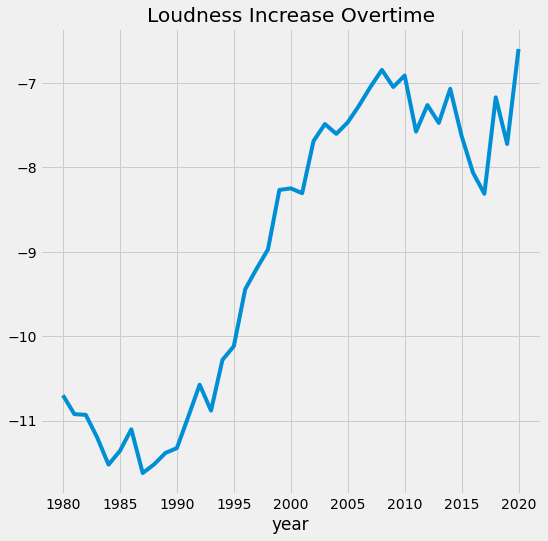

In [157]:
plt.figure(figsize=(8,8))
data_by_year_df[(data_by_year_df.year >= 1980)].groupby('year')['loudness'].mean().plot() #group data by year, take the average duration per year and plot
plt.title('Loudness Increase Overtime')
plt.savefig('../images/loudness-increase-overtime');


-  Loudness, the inherent volume of the music itself, before any adjustments by the listener.
- dynamic range becomes much more restricted. As in, the contrast between the really soft stuff, and the really loud stuff shrinks, so the overall emotional impact of the music is reduced.

In [57]:
data_by_year_df.key.unique()

array([ 2, 10,  0,  5,  9,  7,  1])

In [58]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168388 entries, 1 to 170652
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           168388 non-null  float64
 1   year              168388 non-null  int64  
 2   acousticness      168388 non-null  float64
 3   artists           168388 non-null  object 
 4   danceability      168388 non-null  float64
 5   duration_ms       168388 non-null  int64  
 6   energy            168388 non-null  float64
 7   explicit          168388 non-null  int64  
 8   id                168388 non-null  object 
 9   instrumentalness  168388 non-null  float64
 10  key               168388 non-null  int64  
 11  liveness          168388 non-null  float64
 12  loudness          168388 non-null  float64
 13  mode              168388 non-null  int64  
 14  name              168388 non-null  object 
 15  popularity        168388 non-null  int64  
 16  release_date      16

In [59]:
#convert key data into string 
data_df.key = data_df.key.apply(lambda x: str(x))

In [60]:
data_df.groupby('year')['key'].unique()

year
1921    [7, 3, 5, 2, 0, 1, 8, 9, 10, 4, 11, 6]
1922    [0, 1, 7, 4, 6, 2, 5, 8, 10, 11, 9, 3]
1923    [8, 4, 3, 0, 5, 10, 2, 7, 9, 1, 11, 6]
1924    [2, 3, 8, 0, 10, 7, 5, 11, 9, 1, 6, 4]
1925    [3, 8, 5, 9, 0, 2, 7, 10, 11, 6, 1, 4]
                         ...                  
2016    [6, 8, 0, 10, 1, 5, 7, 9, 4, 3, 11, 2]
2017    [0, 8, 7, 11, 9, 6, 10, 5, 1, 4, 3, 2]
2018    [0, 6, 3, 4, 7, 11, 8, 2, 1, 10, 5, 9]
2019    [0, 2, 10, 8, 1, 7, 5, 4, 6, 11, 3, 9]
2020    [7, 6, 1, 0, 4, 10, 9, 5, 11, 8, 2, 3]
Name: key, Length: 100, dtype: object

In [61]:
#show value count of keys in proportion to overall count for spread of data
data_df[data_df['year'] == 2020]['key'].value_counts(normalize =True)

1     0.138492
0     0.104978
7     0.102021
11    0.099556
5     0.092656
2     0.082307
6     0.081321
10    0.072942
8     0.072449
9     0.069492
4     0.062592
3     0.021193
Name: key, dtype: float64

In [62]:
sample = data_df[data_df['year'] == 2020]['key'].value_counts(normalize =True)

In [63]:
len(sample)

12

In [64]:
#calculate the variance to return a single value
((sample - sample.mean())**2).sum()/(len(sample)-1)

0.0008113660817882333

In [65]:
#test for a different year
sample2 = data_df[data_df['year'] == 2005]['key'].value_counts(normalize =True)

In [66]:
((sample2 - sample2.mean())**2).sum()/(len(sample2)-1)

0.0006302481939649493

In [67]:
#list of variance per year
variance = []

for year in data_df.year.unique():
    #create normalized value count
    normal_data = data_df[data_df['year'] == year]['key'].value_counts(normalize =True)
    # calculate variance
    variance_val = ((normal_data - normal_data.mean())**2).sum()/(len(normal_data)-1)
    #append cariance to list
    variance.append(variance_val)
        

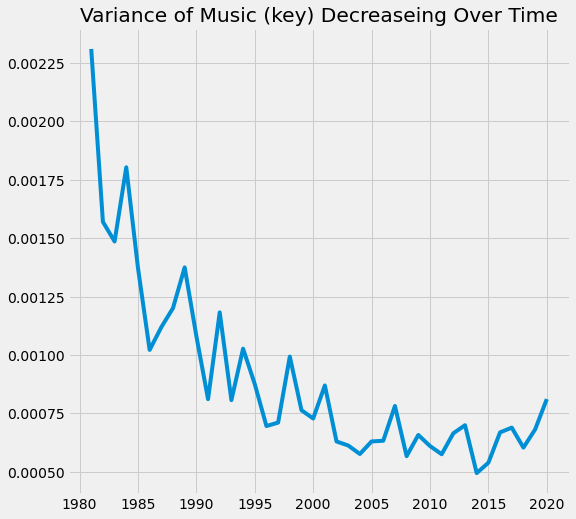

In [175]:
plt.figure(figsize=(8,8))
plt.title('Variance of Music (key) Decreaseing Over Time')
sns.lineplot(y=variance[60:101], x=data_df.year.unique()[60:101])
plt.savefig('../images/variance-of-music-decreasing-over-time',bbox_inches='tight');

Key or pitch includ details about harmony, melody, chords, and progressions – essentially how the notes were arranged and unfolded over the course of the song.

Data suggested that the variety of pitch progressions used has shrunk over the years. In other words, musicians are becoming less inventive and adventurous in how they get from one note or chord to the next, and instead seem to be relying more and more on the same sequences and patterns that others have used successfully in the past.

### summary of EDA thus far

#### music becoming more cookie cutter

-  pitch
    - the data suggested that the variety of pitch progressions used has shrunk over the years
    

- music getting louder 
    - everything is getting louder. Which might not seem like a big deal (just turn down the volume knob, right?), until you start to notice that when everything is louder, the dynamic range becomes much more restricted. As in, the contrast between the really soft stuff, and the really loud stuff shrinks, so the overall emotional impact of the music is reduced. 

## Clustering Songs Together

One of the limitations of content based recommendations, as with others, that it is still known to create a filter bubble. However because the content we are recommending is music based on just audio features, there is still a possibility for recommendations to not be the same genre, epoch or language.

How we can prove this is by clustering the song data. 

### Visualise Songs

In [69]:
#create subset of data for illustrative and clustering purposes
cluster_df = data_df.sample(20000, random_state=42)

#scale data
def scaler(data):
    ss = StandardScaler()
    return ss.fit_transform(data)

cluster_df_scaled = scaler(cluster_df.drop(columns = ['year','id','popularity','explicit','main_artist','feat_artist','release_date','name','artists']))

What is tsne? 

Use to understand high-dimensional data and project it into low-dimensional space (2D).

Can be used in CNN.

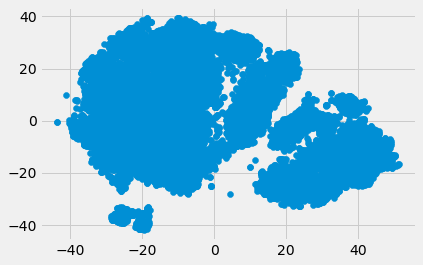

In [70]:
# initiate the model
tsne = TSNE(learning_rate= 100, perplexity = 100)

# fit the model an transform the data
cluster_tsne = tsne.fit_transform(cluster_df_scaled)


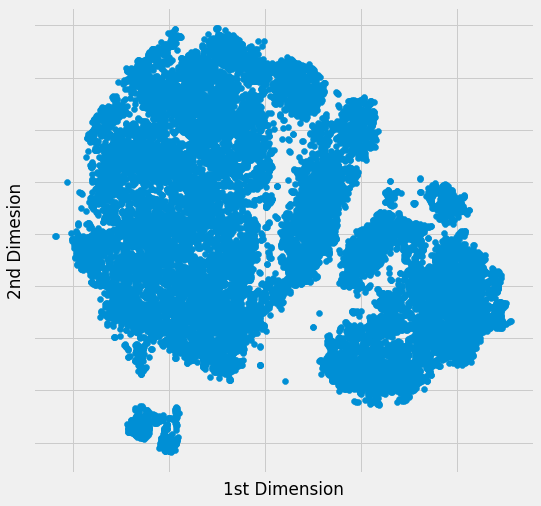

In [190]:
# plot tsne results
plt.figure(figsize=(8,8))

plt.scatter(cluster_tsne[:,0], cluster_tsne[:,1])

plt.ylabel("2nd Dimesion")
plt.xlabel("1st Dimension")

ax = plt.gca()

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.grid(True)

plt.savefig('../images/tsne')
plt.show();

Looks like there are definitely some clusters. I also expect KMeans to perform better than DBSCAN based on the globular shape of the t-SNE results.

### Finding optimal K using elbow method

Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible

In [71]:

K = range(1,21)
distortion = [] #the sum of square error for each data point to their nearest cluster centre
# using for loop
for k in K:
    inertia = KMeans(n_clusters=k).fit(cluster_df_scaled).inertia_
    distortion.append(inertia)



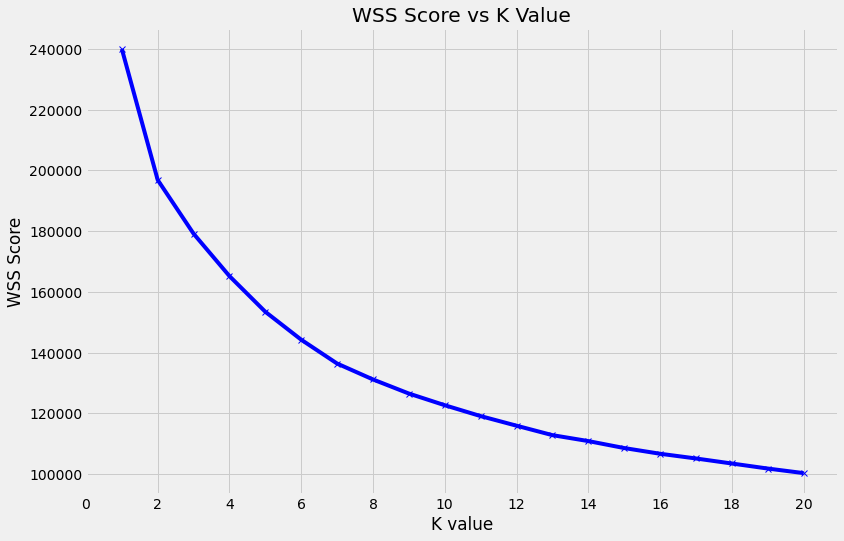

In [203]:
#plot for distortion against k range 50 to select best K
plt.figure(figsize = (12,8))
plt.plot(K, distortion,'bx-')
plt.xticks(np.arange(0,22,2), np.arange(0,22,2))
plt.xlabel('K value')
plt.ylabel('WSS Score')
plt.title('WSS Score vs K Value')
plt.savefig('../images/elbow-method');

We see that the elbow is at K =8, where the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 8.

In [196]:
#reasign kmean's prediction
km_model = KMeans(n_clusters=8,random_state=42).fit(cluster_df_scaled)
grouped_genre = km_model.predict(cluster_df_scaled)

In [197]:
silhouette_score(cluster_df_scaled, km_model.labels_)

0.12755279373944128

In [199]:
cluster_df['km_grouped_genre'] = grouped_genre

Now that we have clustered a sample of our songs, I would like to if see how an artist like Johann Sebastian Bach, a renown classical composer, would be clustered in just more than 1 cluster.

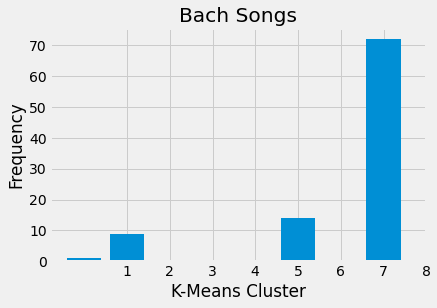

In [223]:
bach = cluster_df[cluster_df.main_artist == "Johann Sebastian Bach"].groupby('km_grouped_genre').count().reset_index()

# plot results
plot = plt.bar(bach["km_grouped_genre"].unique(), bach["name"].sort_values())
plt.xlabel('K-Means Cluster')
plt.ylabel('Frequency')
plt.title('Bach Songs')
plt.xticks(np.arange(1,9), np.arange(1,9))
plt.savefig('../images/bach-songs', bbox_inches='tight');


We can observe a clear tendency of his music towards cluster 1. However this still higlights that by recommending solely of audio features,  The boundaries of music are fluid, and songs from different genres would be neighbours in a given feature space. 

In [149]:
data_df.to_csv('../data/spotify_songs_1922/cleaned_data.csv', index = False)